# Capstone Project - Finding a Better Place in West Vancouver, BC, Canada

In [1]:
# Import all required libraries
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


# Data Extraction and Cleaning

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [3]:
wiki_data

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of postal codes of Canada: V - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"b65b4021-3ccd-42f0-a7fd-e76b4645c441","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_V","wgTitle":"List of postal codes of Canada: V","wgCurRevisionId":1021658434,"wgRevisionId":1021658434,"wgArticleId":966743,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Communications in British C

In [4]:
table_contents=[]
table=wiki_data.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.b.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[0]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

print(table_contents)
df=pd.DataFrame(table_contents)

[{'PostalCode': 'V1A', 'Borough': 'Kimberley', 'Neighborhood': 'Kimberley'}, {'PostalCode': 'V2A', 'Borough': 'Penticton', 'Neighborhood': 'Penticton'}, {'PostalCode': 'V3A', 'Borough': 'Langley Township', 'Neighborhood': 'Langley Township'}, {'PostalCode': 'V4A', 'Borough': 'SurreySouthwest', 'Neighborhood': 'SurreySouthwest'}, {'PostalCode': 'V5A', 'Borough': 'Burnaby', 'Neighborhood': 'Burnaby'}, {'PostalCode': 'V6A', 'Borough': 'Vancouver', 'Neighborhood': 'Vancouver'}, {'PostalCode': 'V7A', 'Borough': 'RichmondSouth', 'Neighborhood': 'RichmondSouth'}, {'PostalCode': 'V8A', 'Borough': 'Powell River', 'Neighborhood': 'Powell River'}, {'PostalCode': 'V9A', 'Borough': 'Victoria', 'Neighborhood': 'Victoria'}, {'PostalCode': 'V1B', 'Borough': 'VernonEast', 'Neighborhood': 'VernonEast'}, {'PostalCode': 'V2B', 'Borough': 'KamloopsNorthwest', 'Neighborhood': 'KamloopsNorthwest'}, {'PostalCode': 'V3B', 'Borough': 'Port CoquitlamCentral', 'Neighborhood': 'Port CoquitlamCentral'}, {'PostalCod

In [5]:
#Delete rows where Borough is 'Not assigned'
df = df[df.Borough!= "Not assigned"]

#Combine all neighbourhoods where postcode and Borough are the same
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
#if Neighbourhood is not assigned, replace by borough name
for index, row in df.iterrows():
    if row['Neighborhood'] == 'Not assigned':
        row['Neighborhood'] = row['Borough']

# define the dataframe columns
column_names = ['PostalCode','Borough', 'Neighborhood'] 

# instantiate the dataframe
df.columns = column_names

df.head()

,PostalCode,Borough,Neighborhood
0,V1A,Kimberley,Kimberley
1,V1B,VernonEast,VernonEast
2,V1C,Cranbrook,Cranbrook
3,V1E,Salmon Arm,Salmon Arm
4,V1G,Dawson Creek,Dawson Creek


In [6]:
df

,PostalCode,Borough,Neighborhood
0,V1A,Kimberley,Kimberley
1,V1B,VernonEast,VernonEast
2,V1C,Cranbrook,Cranbrook
3,V1E,Salmon Arm,Salmon Arm
4,V1G,Dawson Creek,Dawson Creek
5,V1H,VernonWest,VernonWest
6,V1J,Fort St. John,Fort St. John
7,V1K,Merritt,Merritt
8,V1L,Nelson,Nelson
9,V1M,Langley TownshipNorth,Langley TownshipNorth


Converting content of PostalCode HTML table as dataframe

In [7]:
westvancouver = df[129:133]

In [8]:
df = westvancouver.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,V7S,West VancouverNorth,West VancouverNorth
1,V7T,West VancouverSoutheast,West VancouverSoutheast
2,V7V,West VancouverSouth,West VancouverSouth
3,V7W,West VancouverWest,West VancouverWest


In [9]:
df.describe()

,PostalCode,Borough,Neighborhood
count,4,4,4
unique,4,4,4
top,V7T,West VancouverSoutheast,West VancouverSoutheast
freq,1,1,1


In [10]:
df.head()

,PostalCode,Borough,Neighborhood
0,V7S,West VancouverNorth,West VancouverNorth
1,V7T,West VancouverSoutheast,West VancouverSoutheast
2,V7V,West VancouverSouth,West VancouverSouth
3,V7W,West VancouverWest,West VancouverWest


In [11]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['PostalCode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [12]:
df_2

,PostalCode,Borough,Neighborhood
0,V7S,West VancouverNorth,West VancouverNorth
1,V7T,West VancouverSoutheast,West VancouverSoutheast
2,V7V,West VancouverSouth,West VancouverSouth
3,V7W,West VancouverWest,West VancouverWest


In [13]:
print(df_2.shape)

(4, 3)


In [14]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, West Vancouver, BC'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('V7S')

[49.35954000000004, -123.14532999999994]

In [15]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['PostalCode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [16]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [17]:
df_2[df_2.PostalCode == 'V7S']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,V7S,West VancouverNorth,West VancouverNorth,49.35954,-123.14533


In [18]:
from geopy.geocoders import Nominatim
address = 'West Vancouver,BC'

geolocator = Nominatim(user_agent="My App")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of West Vancouver, BC are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of West Vancouver, BC are 49.3311208, -123.1594791.


# Map of West Vancouver

In [19]:
import folium
map_WestVancouver = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_WestVancouver)  
    
map_WestVancouver

In [20]:
address = 'West Vancouver, BC'

geolocator = Nominatim(user_agent="Capstone project")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 49.3311208, -123.1594791.


In [21]:
# @hiddel_cell
CLIENT_ID = '1ORSOYLVG2OUFDNUHRBWOL2PIG5NODCT52K55REL3OFDTPVE' # my Foursquare ID
CLIENT_SECRET = 'EI5H30VOVG2U31XEFX4TMBYEHCJWAHLTKVVOIPDU1Z1JC2GX' # my Foursquare Secret
VERSION = '20210515'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1ORSOYLVG2OUFDNUHRBWOL2PIG5NODCT52K55REL3OFDTPVE
CLIENT_SECRET: EI5H30VOVG2U31XEFX4TMBYEHCJWAHLTKVVOIPDU1Z1JC2GX


In [22]:
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [23]:
results

{'meta': {'code': 200, 'requestId': '60a29f888220f7718bab8209'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Ambleside',
  'headerFullLocation': 'Ambleside, West Vancouver',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 27,
  'suggestedBounds': {'ne': {'lat': 49.3356208045, 'lng': -123.15258682534783},
   'sw': {'lat': 49.3266207955, 'lng': -123.16637137465217}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4aa830eef964a520f04f20e3',
       'name': 'Savary Island Pie Company',
       'location': {'address': '1533 Marine Dr',
        'crossStreet': 'at 15th St',
        'lat': 49.3284971462146,
        'lng': -123.15753919182875,
        'labeledLatLngs': [

In [24]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id',
       'venue.location.neighborhood'],
      dtype='object')

In [25]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Nearby Venues/Locations

In [26]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Savary Island Pie Company,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",49.328497,-123.157539
1,Fresh St. Market,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",49.328052,-123.159513
2,John Lawson Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",49.327194,-123.160297
3,Bene Sushi,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",49.328520,-123.158321
4,Cafe Crema,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",49.327526,-123.156583


# Categories of Nearby Venues/Locations

In [27]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Savary Island Pie Company,Coffee Shop,49.328497,-123.157539
1,Fresh St. Market,Grocery Store,49.328052,-123.159513
2,John Lawson Park,Park,49.327194,-123.160297
3,Bene Sushi,Sushi Restaurant,49.328520,-123.158321
4,Cafe Crema,Coffee Shop,49.327526,-123.156583


In [28]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Coffee Shop           4
Sushi Restaurant      3
Bank                  2
Italian Restaurant    2
Asian Restaurant      2
Grocery Store         1
Pizza Place           1
Food & Drink Shop     1
Thai Restaurant       1
Gas Station           1
Name: categories, dtype: int64

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
# Nearby Venues
WestVancouver_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

West VancouverNorth
West VancouverSoutheast
West VancouverSouth
West VancouverWest


In [31]:
print('There are {} Uniques Categories.'.format(len(WestVancouver_venues['Venue Category'].unique())))
WestVancouver_venues.groupby('Neighborhood').count().head()

There are 18 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
West VancouverNorth,1,1,1,1,1,1
West VancouverSouth,12,12,12,12,12,12
West VancouverSoutheast,6,6,6,6,6,6
West VancouverWest,4,4,4,4,4,4


# One Hot Encoding of Features

In [32]:
# one hot encoding
WestVancouver_onehot = pd.get_dummies(WestVancouver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
WestVancouver_onehot['Neighborhood'] = WestVancouver_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [WestVancouver_onehot.columns[-1]] + list(WestVancouver_onehot.columns[:-1])
WestVancouver_onehot = WestVancouver_onehot[fixed_columns]
WestVancouver_grouped = WestVancouver_onehot.groupby('Neighborhood').mean().reset_index()
WestVancouver_onehot.head(5)

,Neighborhood,American Restaurant,Bakery,Bank,Boat or Ferry,Café,Coffee Shop,Department Store,Gastropub,Grocery Store,Liquor Store,Mexican Restaurant,Pharmacy,Playground,Sushi Restaurant,Tennis Court,Trail,Vietnamese Restaurant,Wine Shop
0,West VancouverNorth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,West VancouverSoutheast,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,West VancouverSoutheast,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,West VancouverSoutheast,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,West VancouverSoutheast,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [33]:
num_top_venues = 5
for hood in WestVancouver_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =WestVancouver_grouped[WestVancouver_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- West VancouverNorth ----
                   venue  freq
0                  Trail   1.0
1    American Restaurant   0.0
2                 Bakery   0.0
3  Vietnamese Restaurant   0.0
4           Tennis Court   0.0


---- West VancouverSouth ----
                   venue  freq
0            Coffee Shop  0.17
1                 Bakery  0.17
2    American Restaurant  0.08
3          Grocery Store  0.08
4  Vietnamese Restaurant  0.08


---- West VancouverSoutheast ----
                venue  freq
0                Bank  0.33
1        Liquor Store  0.17
2  Mexican Restaurant  0.17
3    Department Store  0.17
4            Pharmacy  0.17


---- West VancouverWest ----
                 venue  freq
0        Boat or Ferry  0.25
1                Trail  0.25
2         Tennis Court  0.25
3           Playground  0.25
4  American Restaurant  0.00




In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Most Common Venues in Each Neighborhood

In [35]:
import numpy as np
num_top_venues = 6

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = WestVancouver_grouped['Neighborhood']

for ind in np.arange(WestVancouver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(WestVancouver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,West VancouverNorth,Trail,Wine Shop,Gastropub,Bakery,Bank,Boat or Ferry
1,West VancouverSouth,Bakery,Coffee Shop,Wine Shop,Vietnamese Restaurant,Café,Gastropub
2,West VancouverSoutheast,Bank,Department Store,Pharmacy,Mexican Restaurant,Liquor Store,Wine Shop
3,West VancouverWest,Trail,Tennis Court,Playground,Boat or Ferry,Wine Shop,Department Store


# K-Means Clustering Approach

In [36]:
# Using K-Means to cluster neighborhood into 3 clusters
WestVancouver_grouped_clustering = WestVancouver_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(WestVancouver_grouped_clustering)
kmeans.labels_

array([0, 1, 1, 2], dtype=int32)

In [37]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

WestVancouver_merged =df_2.iloc[:16,:]

# merge WestVancouver_grouped with WestVancouver_data to add latitude/longitude for each neighborhood
WestVancouver_merged = WestVancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

WestVancouver_merged.head()# check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,V7S,West VancouverNorth,West VancouverNorth,49.35954,-123.14533,0,Trail,Wine Shop,Gastropub,Bakery,Bank,Boat or Ferry
1,V7T,West VancouverSoutheast,West VancouverSoutheast,49.33205,-123.13758,1,Bank,Department Store,Pharmacy,Mexican Restaurant,Liquor Store,Wine Shop
2,V7V,West VancouverSouth,West VancouverSouth,49.33737,-123.17716,1,Bakery,Coffee Shop,Wine Shop,Vietnamese Restaurant,Café,Gastropub
3,V7W,West VancouverWest,West VancouverWest,49.34713,-123.26034,2,Trail,Tennis Court,Playground,Boat or Ferry,Wine Shop,Department Store


# Map of Clusters

In [59]:
kclusters = 10

In [58]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(WestVancouver_merged['Latitude'], 
                                   WestVancouver_merged['Longitude'], 
                                   WestVancouver_merged['Neighborhood'], 
                                   WestVancouver_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#2adddd', '#d4dd80', '#ff0000']


In [50]:
df1=WestVancouver_merged.loc[WestVancouver_merged['Cluster Labels'] == 0,WestVancouver_merged.columns[[2] + list(range(5, WestVancouver_merged.shape[1]))]]
df2=WestVancouver_merged.loc[WestVancouver_merged['Cluster Labels'] == 1,WestVancouver_merged.columns[[2] + list(range(5, WestVancouver_merged.shape[1]))]]
df3=WestVancouver_merged.loc[WestVancouver_merged['Cluster Labels'] == 2,WestVancouver_merged.columns[[2] + list(range(5, WestVancouver_merged.shape[1]))]]

In [51]:
WestVancouver_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[3500000.0,4000000.0,4500000.0,3000000.0]})
#Sources: www.zolo.ca

In [52]:
WestVancouver_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

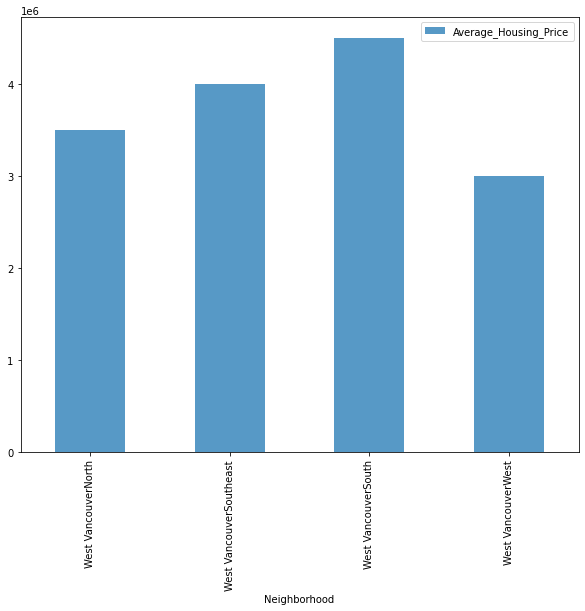

In [53]:
WestVancouver_Avg_HousingPrice.plot(kind='bar',figsize=(10,8),alpha=0.75)

# School Rating by Clusters

In [54]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [55]:
new_WestVancouver=WestVancouver_merged.set_index("Neighborhood",drop=True)
#Source:https://www.compareschoolrankings.org
WestVancouver_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[9.3,9,10,8.5]})

In [56]:
WestVancouver_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

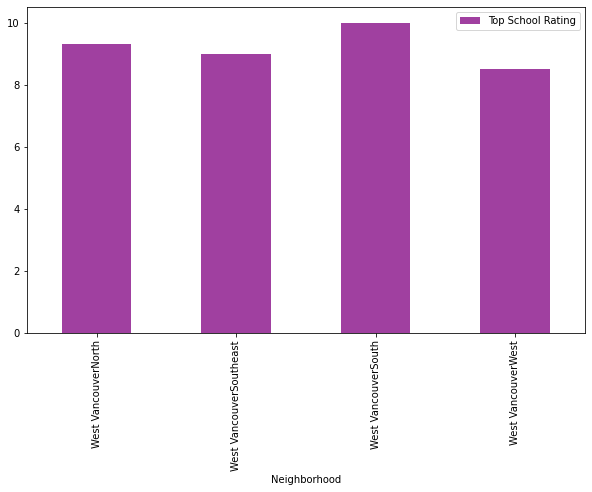

In [47]:
WestVancouver_school_ratings.plot(kind='bar',figsize=(10,6),color='purple',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm ,neighborhood were seperated into 3 different clusters from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made. West Vancouver South neighborhood offers the best elementary school opportunities, however, its average housing price is also the highest in West Vancouver. West Vancouver North neighborhood offers the 2nd best elementary schools, however, its average housing price is 22% lower than that of West Vancouver South. So I would like to recommend West Vancouver North to Adam and his family. 